In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as trn
import skimage as sk
import cv2
import os

%matplotlib inline
BASE_DIR = "/accounts/projects/jsteinhardt/akularora"

In [2]:
test_transform = trn.Compose([trn.Resize(256), trn.CenterCrop(224), trn.ToTensor()])

mean = torch.FloatTensor(np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1))
std = torch.FloatTensor(np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1))

test_data = dset.ImageFolder(os.path.join(BASE_DIR, 'imagenette/imagenette2-320/val'), transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,
                                          num_workers=1, pin_memory=True)

In [3]:
def remove_module(state_dict):
    d = {}
    for key in state_dict:
        d[key[7:]] = state_dict[key]
    return d

net = models.resnet50()
'''
net.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth',
                                       model_dir='/home/hendrycks/datasets/models'))
'''
session = torch.load(os.path.join(BASE_DIR, 'models/deepaugment_and_augmix.pth.tar'), map_location=torch.device('cuda'))
state_dict = remove_module(session['state_dict'])
net.load_state_dict(state_dict)
#'''
net.eval()
cudnn.benchmark = True  # fire on all cylinders

In [4]:
to_np = lambda z: z.to('cpu').detach().numpy()

In [5]:
scale = 0.05
eps = 1
img_noise = 0.5
num_steps = 10
step_size = 10./255
from attacks.snow import add_images
from attacks.snow import SnowAdversary_linf


Clean Image
Loss: 20.446476
Wrong Prediction


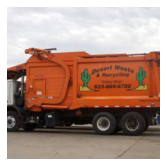


Adversarial Template
1
1 7 56 56


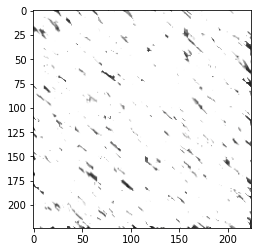

CURRENT LOSS: 19.16961
CURRENT LOSS: 22.239265
CURRENT LOSS: 24.328272
CURRENT LOSS: 26.014605
CURRENT LOSS: 27.075516
CURRENT LOSS: 27.884586
CURRENT LOSS: 28.308567
CURRENT LOSS: 28.647783
CURRENT LOSS: 28.947506
CURRENT LOSS: 29.407778
tensor(0.1255, grad_fn=<MinBackward1>) tensor(1., grad_fn=<MaxBackward1>)
Loss: 30.208778
Wrong Prediction


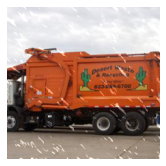

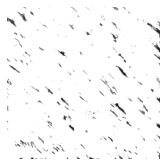

In [6]:
for i, (x, label) in enumerate(test_loader):
    if i < 1:
        adv = SnowAdversary_linf(eps=eps, img_noise = img_noise, scale=scale, num_steps=num_steps, step_size=step_size)
    
        print('\nClean Image')
        target = torch.LongTensor([label])

        x_max, _ = torch.max(x.view(x.size(0), 3, -1), -1)
        x_max = x_max.view(-1, 3, 1, 1)

        logits = net((x - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1) # induced for comparable size
        plt.imshow(to_np(x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        print('\nAdversarial Template')

        adv_x = adv(net, x, target, x_max, mean, std)
        
        logits = net(((add_images(x, adv_x, img_noise))/x_max - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1)
        plt.imshow(to_np(add_images(x, adv_x, img_noise)).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        plt.subplot(1,2,1)
        plt.imshow(to_np(adv_x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()
        
    else:
        break